In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()
plt.rcParams['figure.figsize'] = [10, 5]

In [ ]:
# Load data from tif file
ds = gdal.Open('../data/old/vhExport.tif')#SmallMax.tif')
vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
vh1_band = ds.GetRasterBand(2)
vh1 = vh1_band.ReadAsArray()
vv_band = ds.GetRasterBand(3)
vv = vv_band.ReadAsArray()

# Strip NaNs (I think these appear where data is redacted)
vh[np.isnan(vh)]=np.median(vh[np.isfinite(vh)])-np.std(vh[np.isfinite(vh)])
vh1[np.isnan(vh1)]=np.median(vh1[np.isfinite(vh1)])-np.std(vh1[np.isfinite(vh1)])
vv[np.isnan(vv)]=np.median(vv[np.isfinite(vv)])-np.std(vv[np.isfinite(vv)])

# Apply the upper and lower cutoffs that Harel Dan applied
vh[vh < -25] = -25
vh[vh > 0] = 0
vh1[vh1 < -20] = -20
vh1[vh1 > 10] = 10
vv[vv < -25] = -25
vv[vv > 0] = 0

# Scale to [0, 255]
vh = vh - np.min(vh)
vh = vh / np.max(vh) * 255
vh1 = vh1 - np.min(vh1)
vh1 = vh1 / np.max(vh1) * 255
vv = vv - np.min(vv)
vv = vv / np.max(vv) * 255

# Plot
img = np.zeros([vh.shape[0],vh.shape[1],3])
img[:,:,0] = vh
img[:,:,1] = vh1
img[:,:,2] = vv
r,g,b = cv2.split(img)
rgb = cv2.merge([r, g, b])
rgb = rgb.astype(np.uint8)
plt.imshow(rgb)
plt.savefig('img.png', dpi=600)

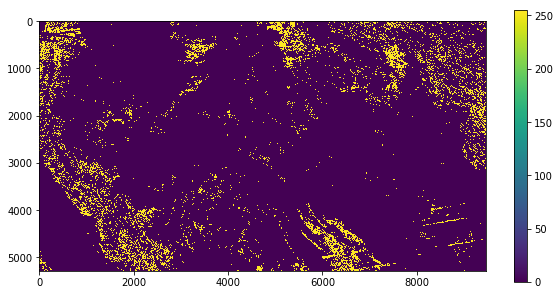

In [126]:
red_m = cv2.inRange(rgb, np.array([100, 0, 0]), np.array([255, 210, 210]))
plt.imshow(red_m)
cbar = plt.colorbar()

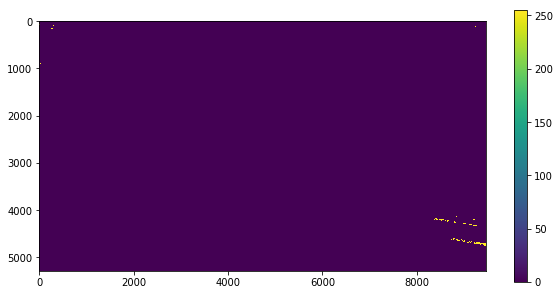

In [127]:
green_m = cv2.inRange(rgb, np.array([0, 110, 0]), np.array([200, 255, 200]))
plt.imshow(green_m)
cbar = plt.colorbar()

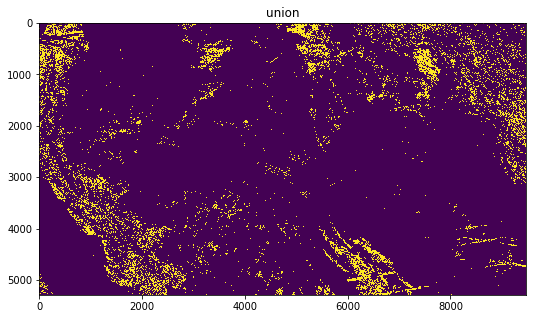

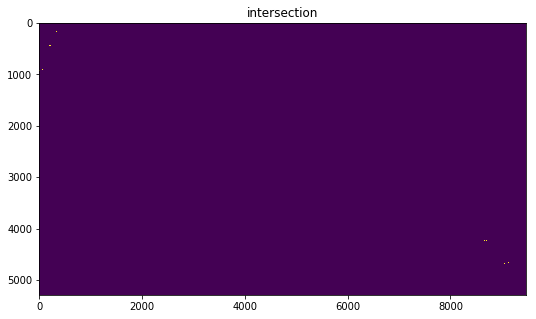

In [128]:
intersection = np.logical_and(green_m, red_m)
union = np.logical_or(green_m, red_m)

plt.imshow(union)
plt.title('union')
plt.show()

plt.imshow(intersection)
plt.title('intersection')
plt.show()

In [122]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on dist (rho) with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    dist = np.array([line[0][0] for line in lines])
    
    # run kmeans on the coords
    labels, centers = cv2.kmeans(dist, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented


def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

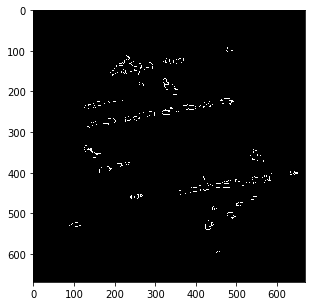

[310.          1.3823009]
[495.          1.4137168]


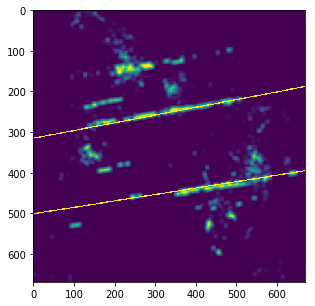

In [123]:
img = red_m.copy()
img = cv2.blur(img, (10, 10))

edges = cv2.Canny(img, 100, 250, apertureSize = 3)
plt.imshow(edges, cmap = 'gray')
plt.show()

lines = cv2.HoughLines(edges, 5, np.pi / 100, 1)#,15)
segmented = segment_by_angle_kmeans(lines[0:10])

for k in range(2):
    for rep in segmented[k][0]:
        print(rep)
        rho = rep[0]
        theta = rep[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

plt.imshow(img)
plt.show()

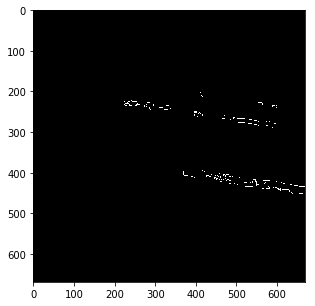

[200.          1.6964601]
[320.         1.759292]


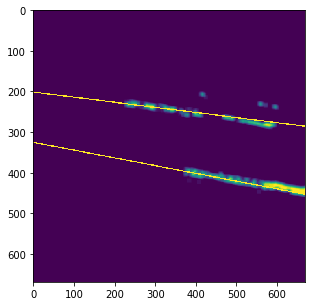

In [124]:
img = green_m.copy()
img = cv2.blur(img, (10, 10))

edges = cv2.Canny(img, 100, 250, apertureSize = 3)
plt.imshow(edges, cmap = 'gray')
plt.show()

lines = cv2.HoughLines(edges, 5, np.pi / 100, 1)#,15)
segmented = segment_by_angle_kmeans(lines[0:10])

for k in range(2):
    for rep in segmented[k][0]:
        print(rep)
        rho = rep[0]
        theta = rep[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

plt.imshow(img)
plt.show()